# Autoencoder Models Performance Analysis

## Notebook Overview 
The purpose of this notebook is to analyze the performance of various Autoencoder architectures through training and evaluation (T&E hereafter) on the CityLearn Challenge 2023 dataset.

### Imports
This section imports essential libraries used throughout the notebook and adds the 'src' directory to the system path to allow importing modules from the source folder. 

In [1]:
import pandas as pd
import numpy as np
import sys
import os
from sklearn.metrics import mean_squared_error
# Getting src path to import modules
src_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))

# Adding src path to the system path, if not already added
if src_path not in sys.path:
    sys.path.append(src_path)

from dl_models import AutoencoderBasic as aeb
from dl_models import AutoencoderAdvanced as aea
from dl_models import AutoencoderRefined as aer
from dl_models import AutoencoderKfold as aek
from utils import plots as plt

## Introductory test
As an initial approach to the model, this T&E will be performed on the samples from Building 1 of the dataset, targeting three features:
- Cooling demand
- Carbon intensity
- Solar generation

In this case, the baseline Autoencoder is adopted, a simple architecture composed of one encoder layer and one decoder layer, each with 64 neurons and linear activation functions.
One plot for each target is generated, highlighting the NMAE, NMSE, and NRMSE, to enable comparison with the normalized performance of other models considered in the project.

In [2]:
# Time series data for a specific building (Building_1.csv/Building_2.csv/Building_3.csv).
electricity_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/Building_1.csv")

# Carbon intensity data.
carbon_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/carbon_intensity.csv")

# Pricing data.
pricing_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/pricing.csv")

# Weather data.
weather_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/weather.csv")

# Concatenate multiple datasets along the columns to create a single dataset.
df = pd.concat([electricity_data, carbon_data, pricing_data, weather_data], axis=1)

# Displaying the last 5 samples of the dataframe to show its structure.
df.tail()

,month,hour,day_type,daylight_savings_status,indoor_dry_bulb_temperature,average_unmet_cooling_setpoint_difference,indoor_relative_humidity,non_shiftable_load,dhw_demand,cooling_demand,...,outdoor_dry_bulb_temperature_predicted_24h,outdoor_relative_humidity_predicted_6h,outdoor_relative_humidity_predicted_12h,outdoor_relative_humidity_predicted_24h,diffuse_solar_irradiance_predicted_6h,diffuse_solar_irradiance_predicted_12h,diffuse_solar_irradiance_predicted_24h,direct_solar_irradiance_predicted_6h,direct_solar_irradiance_predicted_12h,direct_solar_irradiance_predicted_24h
715,6,20,6,0,24.468618,0.024173,54.277103,0.442291,0.398354,5.189857,...,32.905895,89.465866,73.861000,40.875510,0.0,110.15520,0.0,0.0,271.32200,0.0
716,6,21,6,0,24.444859,0.000415,54.351337,0.990416,0.199180,4.550693,...,32.669003,87.158066,66.389130,64.036320,0.0,216.20418,0.0,0.0,151.80556,0.0
717,6,22,6,0,24.444464,0.000019,54.532566,1.563732,0.000000,4.043389,...,29.979940,100.000000,58.228535,51.990180,0.0,259.28485,0.0,0.0,374.21823,0.0
718,6,23,6,0,24.444452,0.000009,54.647182,0.421510,0.000000,3.268111,...,28.337627,90.768420,35.361465,60.445404,0.0,272.40073,0.0,0.0,582.50290,0.0
719,6,24,6,0,21.812447,0.145780,63.234272,0.374985,0.000000,6.492827,...,25.415920,82.899440,47.129494,56.078560,0.0,129.96535,0.0,0.0,842.14680,0.0


In [3]:
# Target features to forecast
targets = ['cooling_demand', 'carbon_intensity', 'solar_generation']

# List of features used for training the autoencoder.
features = ['month', 'hour', 'day_type', 'daylight_savings_status', 'indoor_dry_bulb_temperature', 'average_unmet_cooling_setpoint_difference', 
            'indoor_relative_humidity', 'non_shiftable_load', 'dhw_demand', 'cooling_demand', 'heating_demand', 'solar_generation', 'occupant_count', 
            'indoor_dry_bulb_temperature_set_point', 'hvac_mode', 'carbon_intensity', 'electricity_pricing', 
            'electricity_pricing_predicted_6h', 'electricity_pricing_predicted_12h', 'electricity_pricing_predicted_24h', 
            'outdoor_dry_bulb_temperature', 'outdoor_relative_humidity', 'diffuse_solar_irradiance', 'direct_solar_irradiance', 
            'outdoor_dry_bulb_temperature_predicted_6h', 'outdoor_dry_bulb_temperature_predicted_12h', 'outdoor_dry_bulb_temperature_predicted_24h', 
            'outdoor_relative_humidity_predicted_6h', 'outdoor_relative_humidity_predicted_12h', 'outdoor_relative_humidity_predicted_24h', 
            'diffuse_solar_irradiance_predicted_6h', 'diffuse_solar_irradiance_predicted_12h', 'diffuse_solar_irradiance_predicted_24h', 
            'direct_solar_irradiance_predicted_6h', 'direct_solar_irradiance_predicted_12h', 'direct_solar_irradiance_predicted_24h']

In [4]:
real_1, pred_1 = aeb.Autoencoder(dataframe=df, features=features, epochs = 1000, batch_size=256)

Epoch 1/1000
2/2 [==============================] - 1s 4ms/step - loss: 0.1549 - mean_absolute_error: 0.3433
Epoch 2/1000
2/2 [==============================] - 0s 3ms/step - loss: 0.1379 - mean_absolute_error: 0.3249
Epoch 3/1000
2/2 [==============================] - 0s 6ms/step - loss: 0.1237 - mean_absolute_error: 0.3083
Epoch 4/1000
2/2 [==============================] - 0s 6ms/step - loss: 0.1115 - mean_absolute_error: 0.2929
Epoch 5/1000
2/2 [==============================] - 0s 6ms/step - loss: 0.1008 - mean_absolute_error: 0.2781
Epoch 6/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.0913 - mean_absolute_error: 0.2638
Epoch 7/1000
2/2 [==============================] - 0s 7ms/step - loss: 0.0825 - mean_absolute_error: 0.2494
Epoch 8/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.0744 - mean_absolute_error: 0.2351
Epoch 9/1000
2/2 [==============================] - 0s 4ms/step - loss: 0.0669 - mean_absolute_error: 0.2206
Epoch 10/1000
2/2 [

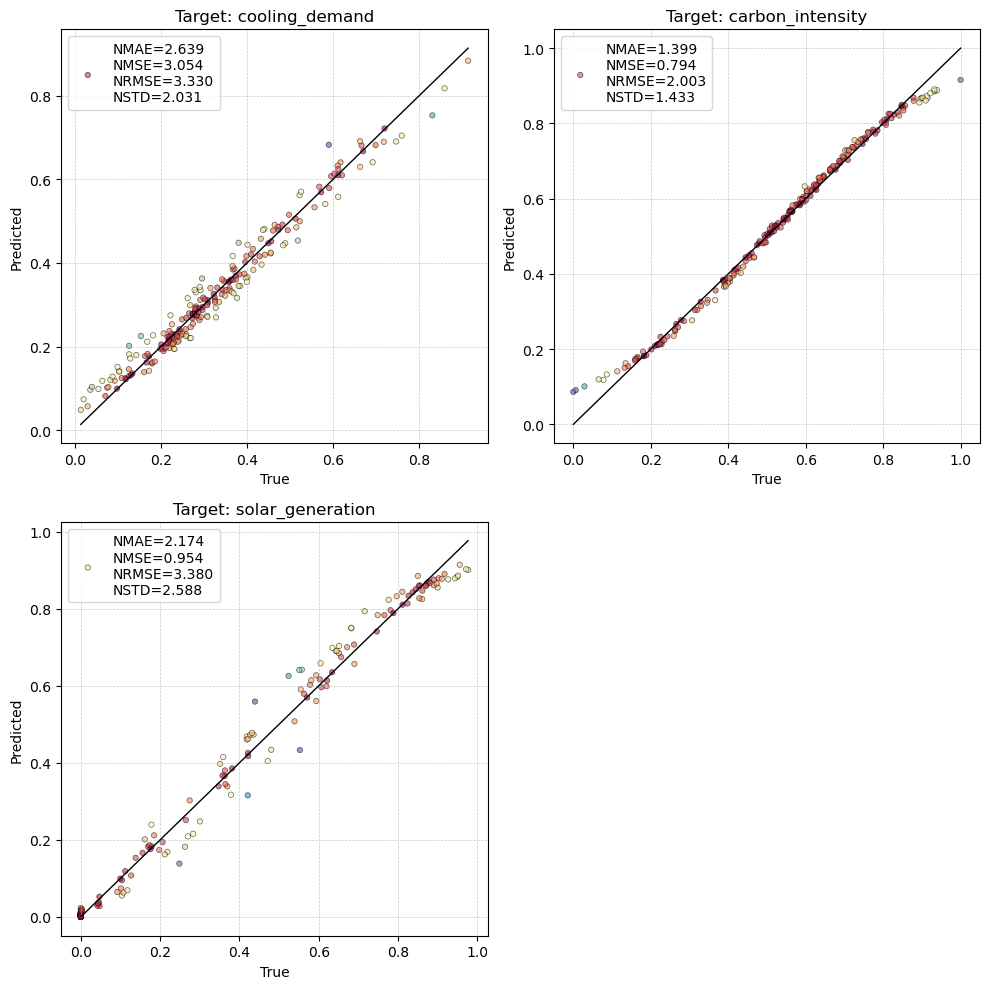

In [5]:
plt.plot_targets(real_1, pred_1, targets, features, percent=True)

## Cross-building test
The targets and the model remain unchanged. For this phase, we will use 100% of the data from Building 1 for training, while the remaining two buildings, being triplets with the first, will be used to evaluate the model's performance.

In [6]:
## Time series data for all buildings
building_1_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/Building_1.csv")
building_2_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/Building_2.csv")
building_3_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/Building_3.csv")

# Concatenate train and test data
train_df = pd.concat([building_1_data, carbon_data, pricing_data, weather_data], axis=1)

# Concatenate the data from Building 2 and Building 3 vertically, creating a unified dataset for evaluation
building_2_3_data = pd.concat([building_2_data, building_3_data], axis=0, ignore_index=True)

# Combine carbon intensity, pricing, and weather data horizontally to align with building data
external_data = pd.concat([carbon_data, pricing_data, weather_data], axis=1)

# Repeat the external data (carbon, pricing, weather) to match the number of rows in Building 2 and 3 data
external_data_repeated = pd.concat([external_data] * 2, axis=0, ignore_index=True)

# Combine the building data and the repeated external data horizontally, preparing the final test dataset
test_df = pd.concat([building_2_3_data, external_data_repeated], axis=1)

In [7]:
train_df.tail()

,month,hour,day_type,daylight_savings_status,indoor_dry_bulb_temperature,average_unmet_cooling_setpoint_difference,indoor_relative_humidity,non_shiftable_load,dhw_demand,cooling_demand,...,outdoor_dry_bulb_temperature_predicted_24h,outdoor_relative_humidity_predicted_6h,outdoor_relative_humidity_predicted_12h,outdoor_relative_humidity_predicted_24h,diffuse_solar_irradiance_predicted_6h,diffuse_solar_irradiance_predicted_12h,diffuse_solar_irradiance_predicted_24h,direct_solar_irradiance_predicted_6h,direct_solar_irradiance_predicted_12h,direct_solar_irradiance_predicted_24h
715,6,20,6,0,24.468618,0.024173,54.277103,0.442291,0.398354,5.189857,...,32.905895,89.465866,73.861000,40.875510,0.0,110.15520,0.0,0.0,271.32200,0.0
716,6,21,6,0,24.444859,0.000415,54.351337,0.990416,0.199180,4.550693,...,32.669003,87.158066,66.389130,64.036320,0.0,216.20418,0.0,0.0,151.80556,0.0
717,6,22,6,0,24.444464,0.000019,54.532566,1.563732,0.000000,4.043389,...,29.979940,100.000000,58.228535,51.990180,0.0,259.28485,0.0,0.0,374.21823,0.0
718,6,23,6,0,24.444452,0.000009,54.647182,0.421510,0.000000,3.268111,...,28.337627,90.768420,35.361465,60.445404,0.0,272.40073,0.0,0.0,582.50290,0.0
719,6,24,6,0,21.812447,0.145780,63.234272,0.374985,0.000000,6.492827,...,25.415920,82.899440,47.129494,56.078560,0.0,129.96535,0.0,0.0,842.14680,0.0


In [8]:
test_df.tail()

,month,hour,day_type,daylight_savings_status,indoor_dry_bulb_temperature,average_unmet_cooling_setpoint_difference,indoor_relative_humidity,non_shiftable_load,dhw_demand,cooling_demand,...,outdoor_dry_bulb_temperature_predicted_24h,outdoor_relative_humidity_predicted_6h,outdoor_relative_humidity_predicted_12h,outdoor_relative_humidity_predicted_24h,diffuse_solar_irradiance_predicted_6h,diffuse_solar_irradiance_predicted_12h,diffuse_solar_irradiance_predicted_24h,direct_solar_irradiance_predicted_6h,direct_solar_irradiance_predicted_12h,direct_solar_irradiance_predicted_24h
1435,6,20,6,0,24.444447,0.000001,55.401950,0.981112,0.000000,3.581775,...,32.905895,89.465866,73.861000,40.875510,0.0,110.15520,0.0,0.0,271.32200,0.0
1436,6,21,6,0,24.444450,0.000005,55.363644,1.070561,0.000000,2.959194,...,32.669003,87.158066,66.389130,64.036320,0.0,216.20418,0.0,0.0,151.80556,0.0
1437,6,22,6,0,24.444450,0.000006,55.452953,0.816532,0.204833,2.480101,...,29.979940,100.000000,58.228535,51.990180,0.0,259.28485,0.0,0.0,374.21823,0.0
1438,6,23,6,0,24.444450,0.000006,55.501358,0.709542,1.768555,3.568882,...,28.337627,90.768420,35.361465,60.445404,0.0,272.40073,0.0,0.0,582.50290,0.0
1439,6,24,6,0,24.444440,-0.000004,55.706670,0.526549,0.000000,1.902680,...,25.415920,82.899440,47.129494,56.078560,0.0,129.96535,0.0,0.0,842.14680,0.0


In [9]:
real_2, pred_2 = aeb.Autoencoder(train_df=train_df, test_df=test_df, features=features, epochs = 3000, batch_size=256)

Epoch 1/3000
3/3 [==============================] - 0s 4ms/step - loss: 0.1454 - mean_absolute_error: 0.3357
Epoch 2/3000
3/3 [==============================] - 0s 4ms/step - loss: 0.1276 - mean_absolute_error: 0.3157
Epoch 3/3000
3/3 [==============================] - 0s 3ms/step - loss: 0.1126 - mean_absolute_error: 0.2971
Epoch 4/3000
3/3 [==============================] - 0s 3ms/step - loss: 0.0985 - mean_absolute_error: 0.2771
Epoch 5/3000
3/3 [==============================] - 0s 3ms/step - loss: 0.0845 - mean_absolute_error: 0.2545
Epoch 6/3000
3/3 [==============================] - 0s 4ms/step - loss: 0.0712 - mean_absolute_error: 0.2298
Epoch 7/3000
3/3 [==============================] - 0s 4ms/step - loss: 0.0598 - mean_absolute_error: 0.2053
Epoch 8/3000
3/3 [==============================] - 0s 3ms/step - loss: 0.0514 - mean_absolute_error: 0.1835
Epoch 9/3000
3/3 [==============================] - 0s 3ms/step - loss: 0.0459 - mean_absolute_error: 0.1664
Epoch 10/3000
3/3 [

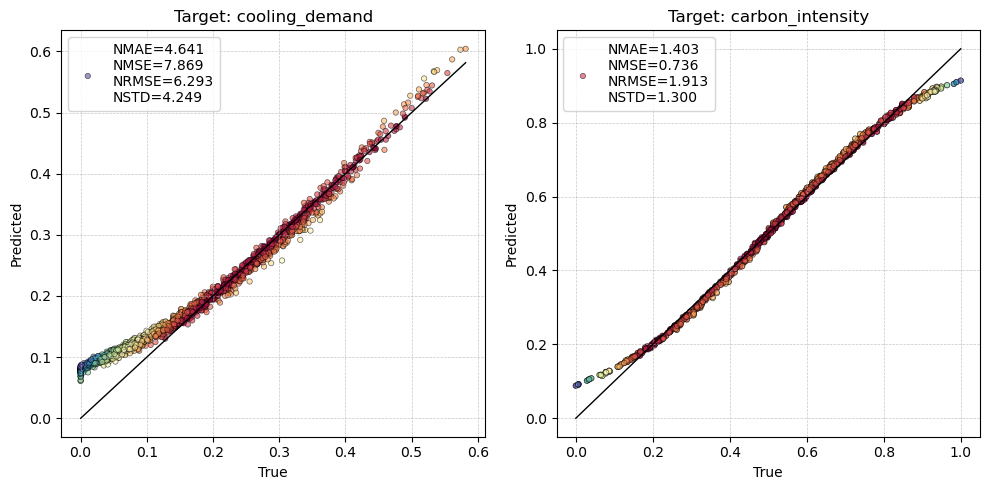

In [10]:
plt.plot_targets(real_2, pred_2, targets[:2], features, percent=True)

## Enhanced Architectures test
In this section, we evaluate the previous tests on a more advanced autoencoder architecture, designed to improve the model's ability to learn from complex data and potentially reduce errors. This architecture introduces deeper layers, different activation functions, and other optimizations aimed at enhancing performance over the previous model.

### Adding Hidden Layers

Now, two hidden layers are added to both the encoder and decoder in order to enhance the model’s representation capacity.

Encoder:
- Dense layer with 128 units and linear activation;
- Dense layer with 64 units and linear activation;
- Dense layer with 32 units and linear activation.

Bottleneck (latent) layer with n units and linear activation.

Decoder:
- Dense layer with 32 units and linear activation;
- Dense layer with 64 units and linear activation;
- Dense layer with 128 units and linear activation.

Output layer with a sigmoid activation to reconstruct the input.

This structure is designed to capture more complex relationships within the data while maintaining symmetry between the encoding and decoding paths.

In [11]:
real_3, pred_3 = aea.Autoencoder(dataframe=df, features=features, epochs = 1000, batch_size = 64)

Epoch 1/1000
8/8 [==============================] - 0s 4ms/step - loss: 0.0831 - mean_absolute_error: 0.2329
Epoch 2/1000
8/8 [==============================] - 0s 5ms/step - loss: 0.0348 - mean_absolute_error: 0.1193
Epoch 3/1000
8/8 [==============================] - 0s 3ms/step - loss: 0.0243 - mean_absolute_error: 0.1023
Epoch 4/1000
8/8 [==============================] - 0s 4ms/step - loss: 0.0185 - mean_absolute_error: 0.0911
Epoch 5/1000
8/8 [==============================] - 0s 4ms/step - loss: 0.0146 - mean_absolute_error: 0.0800
Epoch 6/1000
8/8 [==============================] - 0s 4ms/step - loss: 0.0122 - mean_absolute_error: 0.0731
Epoch 7/1000
8/8 [==============================] - 0s 5ms/step - loss: 0.0104 - mean_absolute_error: 0.0668
Epoch 8/1000
8/8 [==============================] - 0s 5ms/step - loss: 0.0091 - mean_absolute_error: 0.0621
Epoch 9/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.0082 - mean_absolute_error: 0.0578
Epoch 10/1000
8/8 [

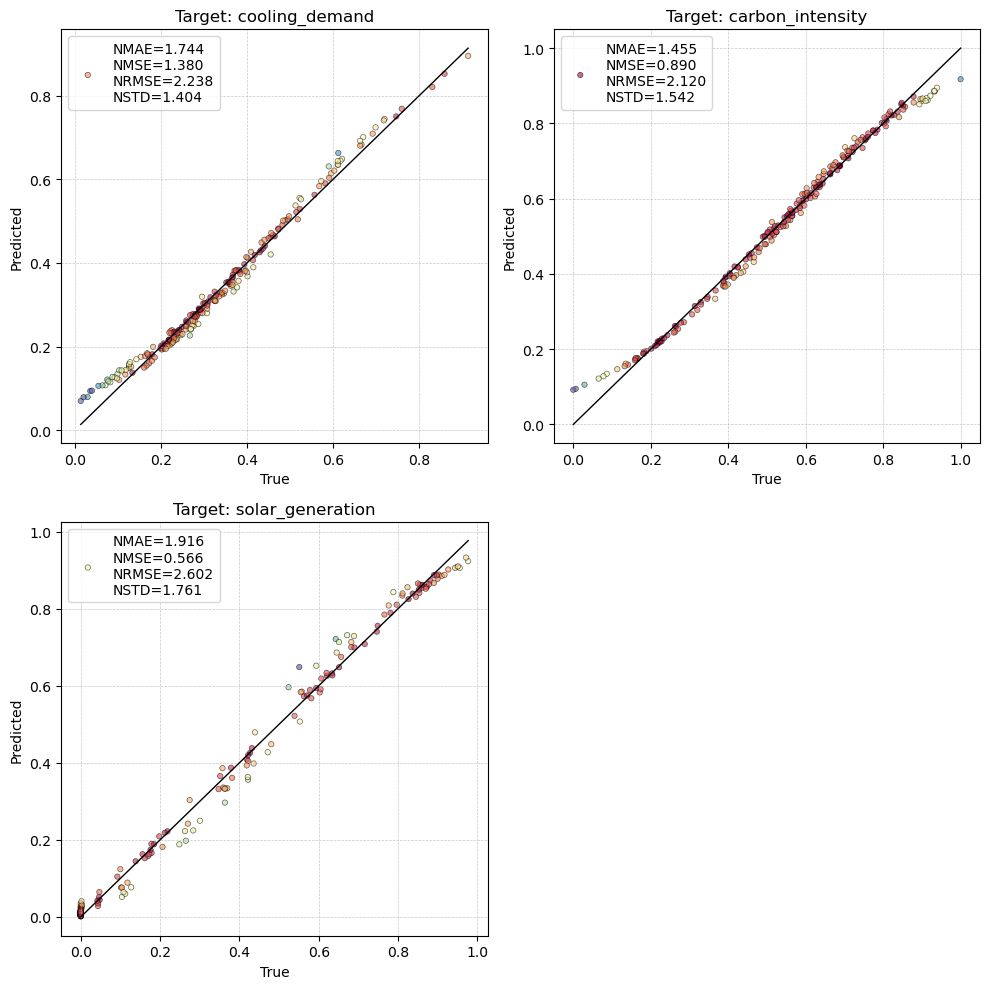

In [12]:
plt.plot_targets(real_3, pred_3, targets, features, percent=True)

In [13]:
real_4, pred_4 = aea.Autoencoder(train_df=train_df, test_df=test_df, features=features, epochs = 3000, batch_size = 64)

Epoch 1/3000
12/12 [==============================] - 0s 4ms/step - loss: 0.0672 - mean_absolute_error: 0.1944
Epoch 2/3000
12/12 [==============================] - 0s 3ms/step - loss: 0.0280 - mean_absolute_error: 0.1055
Epoch 3/3000
12/12 [==============================] - 0s 4ms/step - loss: 0.0182 - mean_absolute_error: 0.0904
Epoch 4/3000
12/12 [==============================] - 0s 3ms/step - loss: 0.0131 - mean_absolute_error: 0.0756
Epoch 5/3000
12/12 [==============================] - 0s 4ms/step - loss: 0.0106 - mean_absolute_error: 0.0669
Epoch 6/3000
12/12 [==============================] - 0s 4ms/step - loss: 0.0089 - mean_absolute_error: 0.0609
Epoch 7/3000
12/12 [==============================] - 0s 4ms/step - loss: 0.0076 - mean_absolute_error: 0.0560
Epoch 8/3000
12/12 [==============================] - 0s 4ms/step - loss: 0.0067 - mean_absolute_error: 0.0525
Epoch 9/3000
12/12 [==============================] - 0s 5ms/step - loss: 0.0061 - mean_absolute_error: 0.0499
E

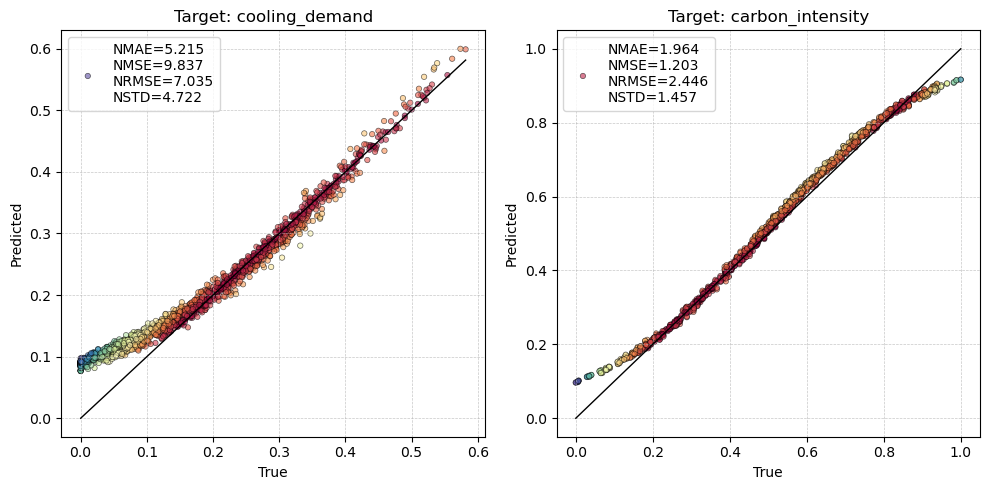

In [14]:
plt.plot_targets(real_4, pred_4, targets[:2], features, percent=True)

### Introducing Non Linear Activation Functions and Model Enhancements

To further improve the reconstruction performance, this section introduces non-linear activation functions (e.g. ReLU, ELU) within the hidden layers of the autoencoder. Additionally, the model configuration is enhanced by experimenting with a different optimizer, adjusting the dimensionality of the latent space and adding the batch normalization procedure after every layer. These changes aim to boost the model’s representation power and optimize its ability to reconstruct complex patterns in the input features.

In [15]:
real_5, pred_5, _ = aer.Autoencoder(dataframe=df, features=features, epochs = 1000, latent_dim = 32, batch_size = 128)

Epoch 1/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1378 - mean_absolute_error: 0.3304
Epoch 2/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1292 - mean_absolute_error: 0.3206
Epoch 3/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1194 - mean_absolute_error: 0.3087
Epoch 4/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1079 - mean_absolute_error: 0.2939
Epoch 5/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0950 - mean_absolute_error: 0.2758
Epoch 6/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0822 - mean_absolute_error: 0.2552
Epoch 7/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0707 - mean_absolute_error: 0.2334
Epoch 8/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0618 - mean_absolute_error: 0.2131
Epoch 9/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0561 - mean_absolute_error: 0.1959
Epoch 10/1000
4/4 [

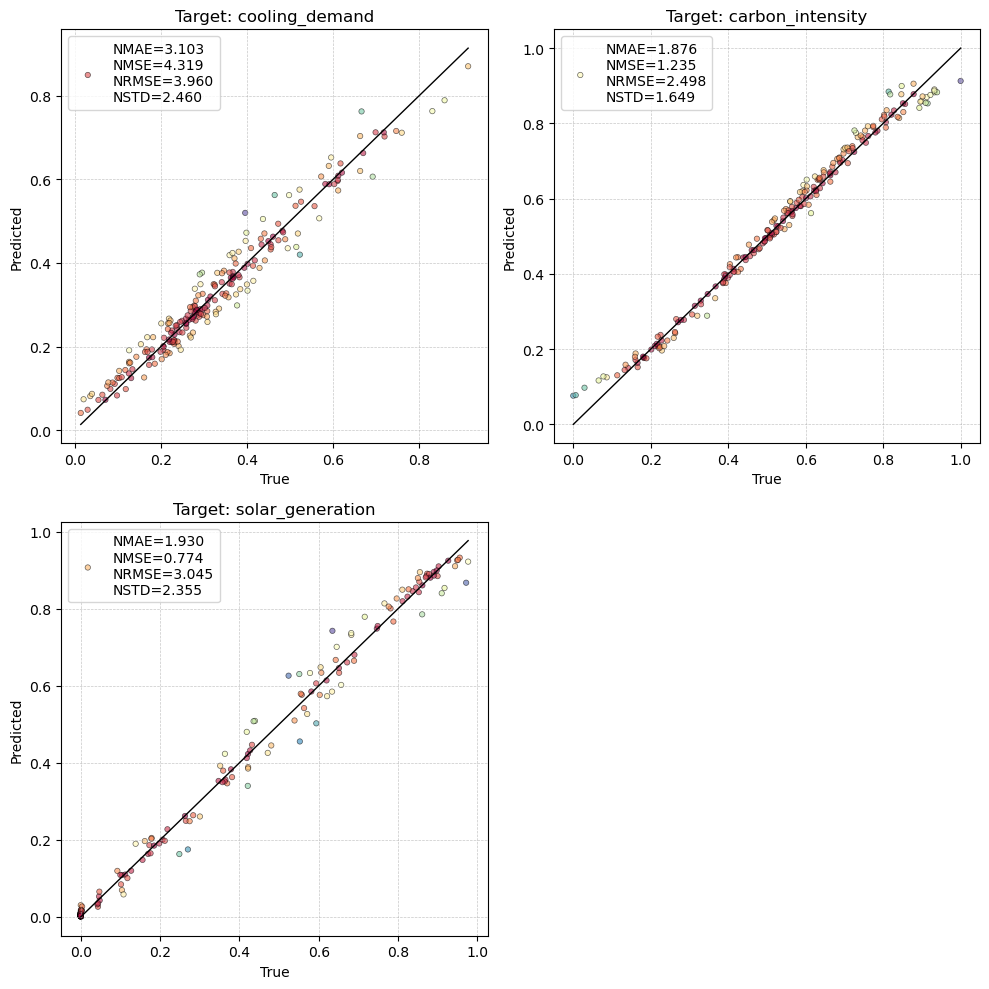

In [16]:
plt.plot_targets(real_5, pred_5, targets, features, percent=True)

In [17]:
real_6, pred_6, model = aer.Autoencoder(train_df=train_df, test_df=test_df, features=features, epochs = 3000, latent_dim = 32, batch_size = 128)
model.save(os.path.join("..", "reports", "models", "autoencoder_generalization.h5"))

Epoch 1/3000
6/6 [==============================] - 1s 7ms/step - loss: 0.1359 - mean_absolute_error: 0.3273
Epoch 2/3000
6/6 [==============================] - 0s 8ms/step - loss: 0.1213 - mean_absolute_error: 0.3105
Epoch 3/3000
6/6 [==============================] - 0s 8ms/step - loss: 0.1059 - mean_absolute_error: 0.2904
Epoch 4/3000
6/6 [==============================] - 0s 7ms/step - loss: 0.0893 - mean_absolute_error: 0.2657
Epoch 5/3000
6/6 [==============================] - 0s 7ms/step - loss: 0.0740 - mean_absolute_error: 0.2385
Epoch 6/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0620 - mean_absolute_error: 0.2122
Epoch 7/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0538 - mean_absolute_error: 0.1907
Epoch 8/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0484 - mean_absolute_error: 0.1750
Epoch 9/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0443 - mean_absolute_error: 0.1630
Epoch 10/3000
6/6 [

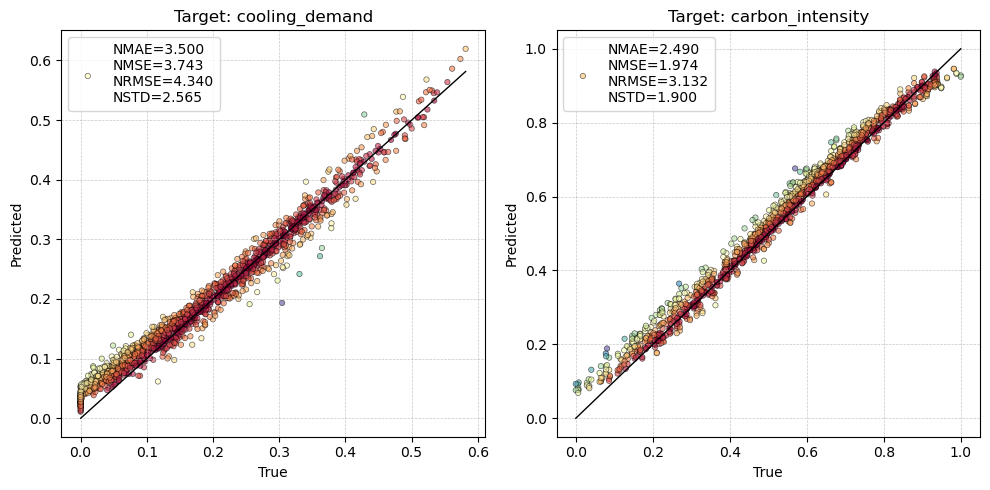

In [18]:
plt.plot_targets(real_6, pred_6, targets[:2], features, percent=True)

### Adding K-fold Cross-validation

#### Tuning
In this phase, the autoencoder is trained and evaluated using K-Fold Cross Validation, a technique that splits the dataset into k subsets (folds). Each fold is used once as a validation set while the remaining k-1 folds are used for training.
The base architecture used for the autoencoder in this phase is the same as the model described in the previous section, allowing the results to be compared effectively.

In [19]:
real_7, pred_7, model = aek.Autoencoder(dataframe=df, features=features, epochs = 200, latent_dim = 64, batch_size = 32, kfold = 10)
model.save(os.path.join("..", "reports", "models", "autoencoder_kfoldtuning.h5"))

Fold 1/10
Epoch 1/200
21/21 [==============================] - 1s 15ms/step - loss: 0.1186 - mean_absolute_error: 0.3062 - val_loss: 0.0839 - val_mean_absolute_error: 0.2557
Epoch 2/200
21/21 [==============================] - 0s 7ms/step - loss: 0.0637 - mean_absolute_error: 0.2165 - val_loss: 0.0523 - val_mean_absolute_error: 0.1775
Epoch 3/200
21/21 [==============================] - 0s 5ms/step - loss: 0.0424 - mean_absolute_error: 0.1592 - val_loss: 0.0393 - val_mean_absolute_error: 0.1436
Epoch 4/200
21/21 [==============================] - 0s 8ms/step - loss: 0.0322 - mean_absolute_error: 0.1331 - val_loss: 0.0326 - val_mean_absolute_error: 0.1257
Epoch 5/200
21/21 [==============================] - 0s 6ms/step - loss: 0.0266 - mean_absolute_error: 0.1158 - val_loss: 0.0282 - val_mean_absolute_error: 0.1136
Epoch 6/200
21/21 [==============================] - 0s 6ms/step - loss: 0.0235 - mean_absolute_error: 0.1067 - val_loss: 0.0259 - val_mean_absolute_error: 0.1081
Epoch 7/200

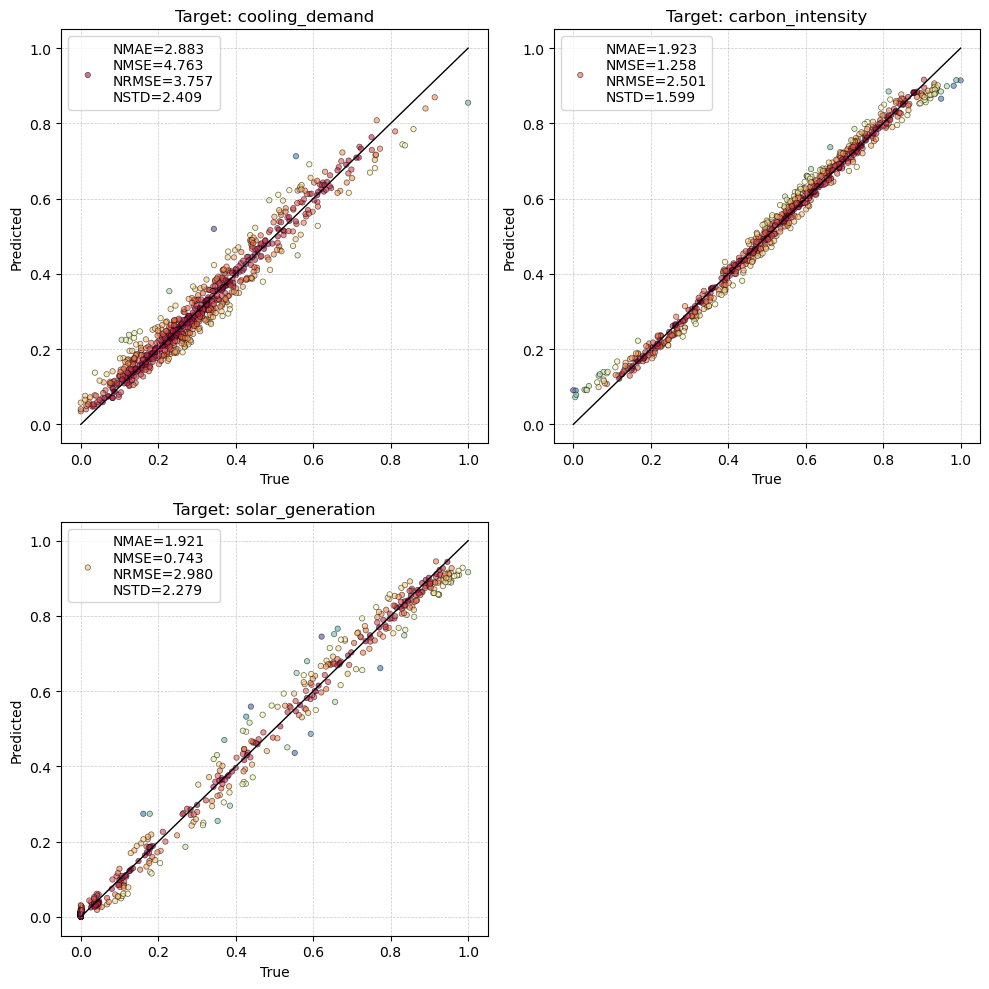

In [20]:
plt.plot_targets(real_7, pred_7, targets, features, percent=True)

#### Final Training
After choosing the best hyperparameters during the tuning phase with K-Fold Cross Validation, the model is trained on the full available dataset.
The model is trained using data from one or more buildings and then tested on a different building that was never used during training.
This method checks how well the model can generalize and perform on new, unseen data with different characteristics. It provides a more realistic and reliable evaluation for real-world situations where the model faces new buildings or environments.

In [21]:
electricity_d = pd.read_csv("../data/citylearn_challenge_2023_phase_1/Building_2.csv")
df2 = pd.concat([electricity_d, carbon_data, pricing_data, weather_data], axis=1)

In [22]:
real_8, pred_8, model = aek.Autoencoder(dataframe=df2, features=features, epochs = 1000, latent_dim = 64, batch_size = 32)
model.save(os.path.join("..", "reports", "models", "autoencoder_kfoldtrain.h5"))

Epoch 1/1000
16/16 [==============================] - 0s 4ms/step - loss: 0.1326 - mean_absolute_error: 0.3305
Epoch 2/1000
16/16 [==============================] - 0s 4ms/step - loss: 0.0796 - mean_absolute_error: 0.2496
Epoch 3/1000
16/16 [==============================] - 0s 4ms/step - loss: 0.0530 - mean_absolute_error: 0.1808
Epoch 4/1000
16/16 [==============================] - 0s 4ms/step - loss: 0.0431 - mean_absolute_error: 0.1539
Epoch 5/1000
16/16 [==============================] - 0s 4ms/step - loss: 0.0355 - mean_absolute_error: 0.1383
Epoch 6/1000
16/16 [==============================] - 0s 4ms/step - loss: 0.0314 - mean_absolute_error: 0.1258
Epoch 7/1000
16/16 [==============================] - 0s 4ms/step - loss: 0.0280 - mean_absolute_error: 0.1164
Epoch 8/1000
16/16 [==============================] - 0s 4ms/step - loss: 0.0253 - mean_absolute_error: 0.1101
Epoch 9/1000
16/16 [==============================] - 0s 4ms/step - loss: 0.0234 - mean_absolute_error: 0.1045
E

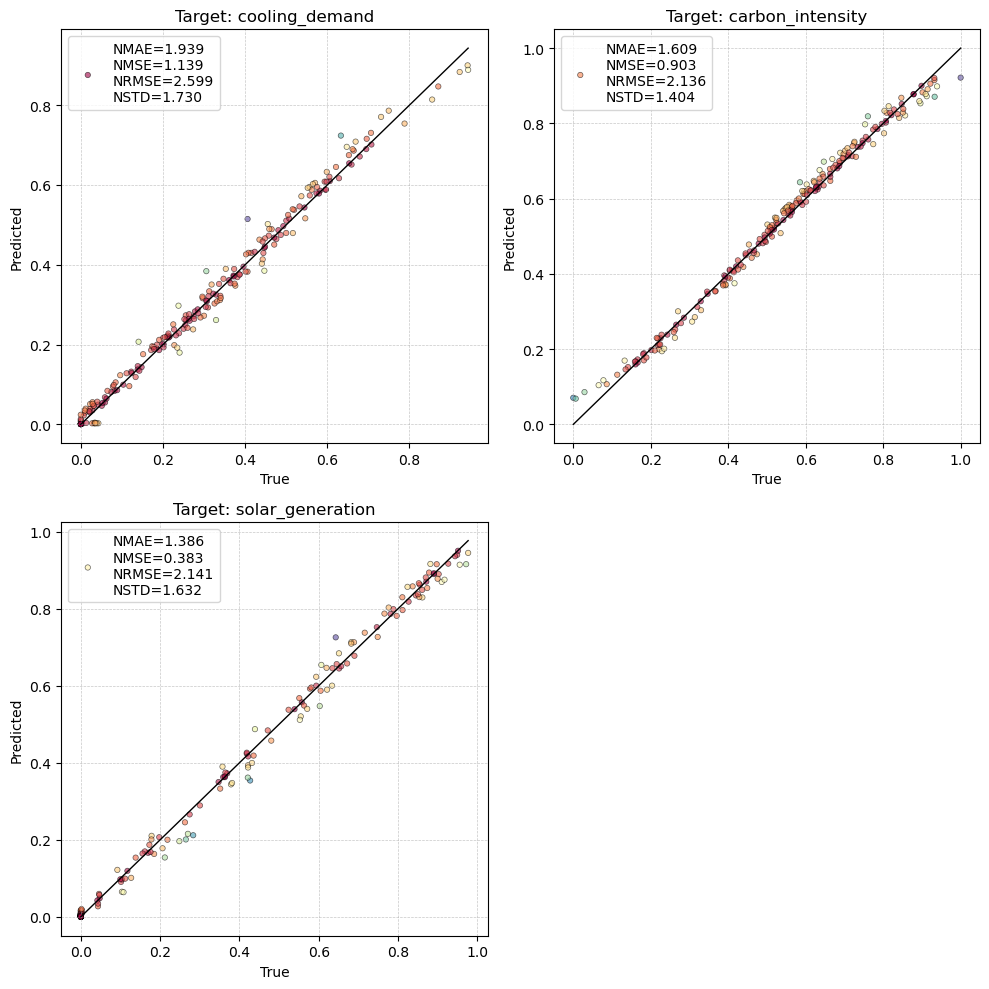

In [23]:
plt.plot_targets(real_8, pred_8, targets, features, percent=True)